In [42]:
import warnings
warnings.simplefilter('ignore')


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import listdir
from os.path import isfile, join
import glob

import keras 
import tensorflow as tf
print(tf.__version__)
import numpy as np
from matplotlib import pyplot as plt
from shutil import copyfile
from random import seed
from random import random

from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.utils import image_dataset_from_directory,load_img
from keras.applications import vgg16
from pathlib import Path

import PIL
from PIL import Image, ImageOps

from sklearn.utils import shuffle
from sklearn import metrics

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
   
from keras.callbacks import LearningRateScheduler


2.11.0


In [43]:
seed = 10
split = 0.2
img_rows, img_cols = 150, 150
path = './flowers'
labels = [fn.split('/')[2] for fn in [join(path,f) for f in listdir(path)]]

In [44]:
labels

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [45]:

train_datagen = ImageDataGenerator(
    validation_split = split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True,
    # preprocessing_function=to_grayscale_then_rgb
)

val_datagen = ImageDataGenerator(
    validation_split = split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True,
    # preprocessing_function=to_grayscale_then_rgb
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    # preprocessing_function=to_grayscale_then_rgb
)

In [46]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = 32, 
    class_mode='categorical',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)
num_class =train_generator.num_classes

Found 3457 images belonging to 5 classes.


In [47]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = 32, 
    class_mode='categorical',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 860 images belonging to 5 classes.


In [48]:
IMG_DIM = (img_rows, img_cols)

train_files = glob.glob('./flowers/daisy/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]

Labels: ['10172636503_21bededa75_n', '10172636503_21bededa75_n', '10172636503_21bededa75_n', '10172636503_21bededa75_n', '10172636503_21bededa75_n', '10172636503_21bededa75_n', '10172636503_21bededa75_n', '10172636503_21bededa75_n', '10172636503_21bededa75_n', '10172636503_21bededa75_n']


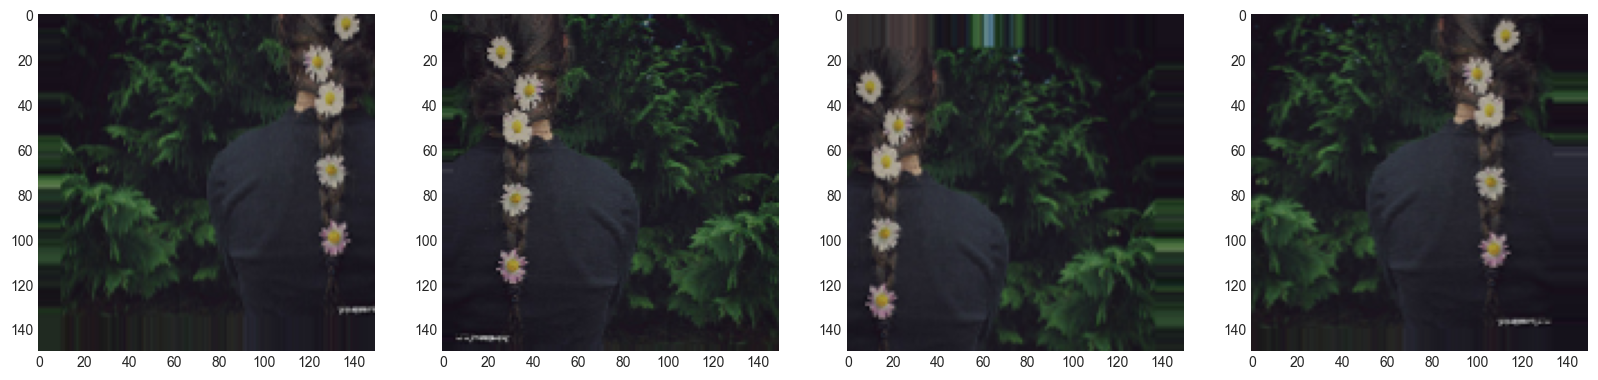

In [49]:
IMG_DIM = (img_rows, img_cols)

train_files = glob.glob('./flowers/daisy/*')
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]
img_id  = np.random.randint(100)
diasy_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
diasy = [next(diasy_generator) for i in range(0,10)]
fig, ax = plt.subplots(1,4, figsize=(20, 12))
print('Labels:', [item[1][0] for item in diasy])
l = [ax[i].imshow(diasy[i][0][0]) for i in range(0,4)]

In [50]:
plt.style.use('seaborn-v0_8-dark')
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid(True)
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.grid(True)

keras_callbacks = [
      EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01),
]

callbacks_list_ = [keras_callbacks]

In [12]:
from keras.applications import vgg16
input_shape = (img_rows, img_cols, 3)

vgg16 = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape,
                    classifier_activation='softmax')

output = vgg16.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel_vgg16 = Model(vgg16.input, output)

basemodel_vgg16.trainable = False
for layer in basemodel_vgg16.layers: layer.trainable = False

input_shape = basemodel_vgg16.output_shape[1]

2024-06-17 18:04:25.529280: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [13]:
model_vgg16 = Sequential()
model_vgg16.add(basemodel_vgg16)
model_vgg16.add(Dense(num_class, activation='softmax'))
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dense (Dense)               (None, 5)                 40965     
                                                                 
Total params: 14,755,653
Trainable params: 40,965
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
model_vgg16.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_vgg16_history = model_vgg16.fit(train_generator,
                               # steps_per_epoch=100,
                               epochs=60,
                               validation_data=val_generator, 
                               # validation_steps=20,
                               callbacks = callbacks_list_,
                               verbose=1,
                              ) 

Epoch 1/60
109/109 [==============================] - 537s 5s/step - loss: 0.9031 - accuracy: 0.6590 - val_loss: 0.7142 - val_accuracy: 0.7337
Epoch 2/60
109/109 [==============================] - 507s 5s/step - loss: 0.6263 - accuracy: 0.7813 - val_loss: 0.6358 - val_accuracy: 0.7791
Epoch 3/60
109/109 [==============================] - 547s 5s/step - loss: 0.5476 - accuracy: 0.8091 - val_loss: 0.6394 - val_accuracy: 0.7558
Epoch 4/60
109/109 [==============================] - 519s 5s/step - loss: 0.5285 - accuracy: 0.8123 - val_loss: 0.6102 - val_accuracy: 0.7733
Epoch 5/60
109/109 [==============================] - 537s 5s/step - loss: 0.4553 - accuracy: 0.8351 - val_loss: 0.6234 - val_accuracy: 0.7756
Epoch 6/60
109/109 [==============================] - 535s 5s/step - loss: 0.4203 - accuracy: 0.8493 - val_loss: 0.5896 - val_accuracy: 0.7907
Epoch 7/60
109/109 [==============================] - 573s 5s/step - loss: 0.3876 - accuracy: 0.8635 - val_loss: 0.6166 - val_accuracy: 0.7616

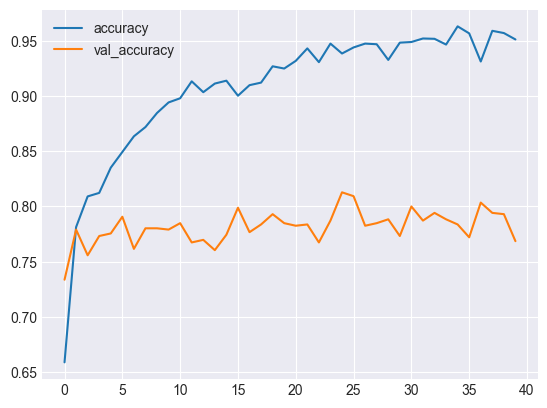

In [15]:
plot_accuracy(model_vgg16_history)

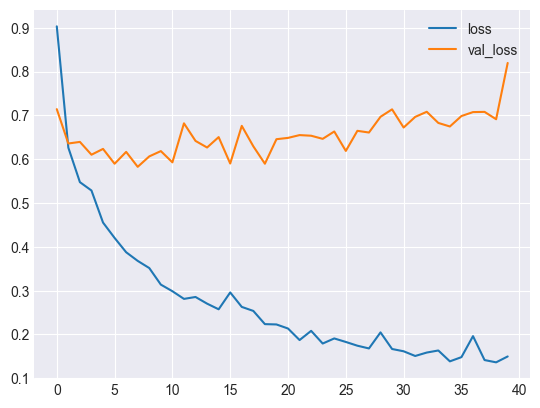

In [16]:
plot_loss(model_vgg16_history)

In [22]:
model_vgg16.save('model_vgg16_original')

INFO:tensorflow:Assets written to: model_vgg16_original/assets


INFO:tensorflow:Assets written to: model_vgg16_original/assets


In [24]:
model_vgg16_original = tf.keras.models.load_model('model_vgg16_original')

In [11]:
from keras.applications import InceptionV3



input_shape = (img_rows, img_cols, 3)
Incept_1 = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=num_class,
    classifier_activation="softmax"
)

output = Incept_1.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel_Incept_1 = Model(Incept_1.input, output)
basemodel_Incept_1.trainable = False
for layer in basemodel_Incept_1.layers: 
    layer.trainable = False

input_shape = basemodel_Incept_1.output_shape[1]

In [12]:
basemodel_Incept_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [13]:
model_incept = Sequential()
model_incept.add(basemodel_Incept_1)
# model4.add(Dense(1048, activation='relu', input_dim=input_shape))
# model4.add(Dropout(0.3))
# model4.add(Dense(128, activation='relu', input_dim=input_shape))
model_incept.add(Dense(num_class, activation='softmax'))
                 
                 
model_incept.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                 
                 
model_incept.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 18432)             21802784  
                                                                 
 dense (Dense)               (None, 5)                 92165     
                                                                 
Total params: 21,894,949
Trainable params: 92,165
Non-trainable params: 21,802,784
_________________________________________________________________


In [14]:
model_incept_history = model_incept.fit(train_generator,
                               epochs=60,
                               validation_data=val_generator, 
                                 callbacks = callbacks_list_,
                               verbose=1,
                              )  

Epoch 1/60
109/109 [==============================] - 184s 2s/step - loss: 1.6282 - accuracy: 0.7026 - val_loss: 1.6399 - val_accuracy: 0.7209
Epoch 2/60
109/109 [==============================] - 162s 1s/step - loss: 0.9999 - accuracy: 0.7958 - val_loss: 1.3448 - val_accuracy: 0.7512
Epoch 3/60
109/109 [==============================] - 174s 2s/step - loss: 0.9216 - accuracy: 0.8181 - val_loss: 1.7120 - val_accuracy: 0.7384
Epoch 4/60
109/109 [==============================] - 171s 2s/step - loss: 1.3275 - accuracy: 0.8033 - val_loss: 1.8571 - val_accuracy: 0.7733
Epoch 5/60
109/109 [==============================] - 168s 2s/step - loss: 1.0234 - accuracy: 0.8334 - val_loss: 1.9771 - val_accuracy: 0.7419
Epoch 6/60
109/109 [==============================] - 178s 2s/step - loss: 0.8487 - accuracy: 0.8504 - val_loss: 1.7779 - val_accuracy: 0.7593
Epoch 7/60
109/109 [==============================] - 161s 1s/step - loss: 0.6908 - accuracy: 0.8678 - val_loss: 2.1226 - val_accuracy: 0.7477

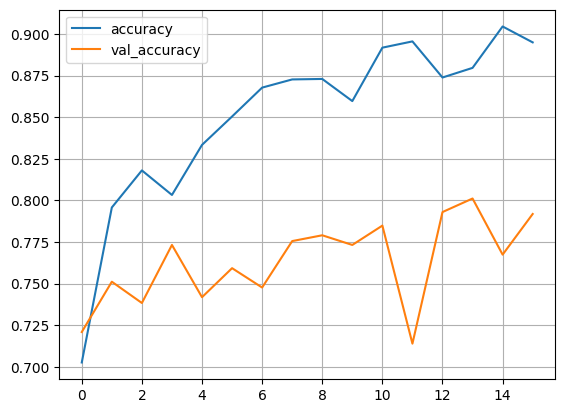

In [15]:
plot_accuracy(model_incept_history)

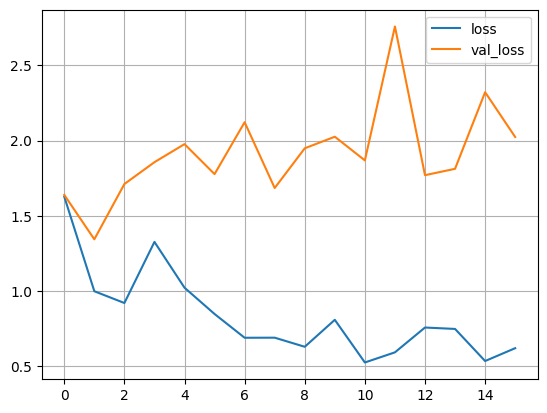

In [16]:
plot_loss(model_incept_history)

In [17]:
model_incept.save('model_incept_original')

INFO:tensorflow:Assets written to: model_incept_original/assets


INFO:tensorflow:Assets written to: model_incept_original/assets


In [51]:
model_incept_original = tf.keras.models.load_model('model_incept_original')

In [17]:
from keras.applications import ResNet152V2

input_shape = (img_rows, img_cols, 3)
res = ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=num_class,
    classifier_activation="softmax"
)

output = res.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel_res = Model(res.input, output)
basemodel_res.trainable = False
for layer in basemodel_res.layers: 
    layer.trainable = False

input_shape = basemodel_res.output_shape[1]

In [18]:
basemodel_res.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']       

In [19]:
model_res = Sequential()
model_res.add(basemodel_res)
model_res.add(Dense(num_class, activation='softmax'))
                 
                 
model_res.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                 
                 
model_res.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 51200)             58331648  
                                                                 
 dense_1 (Dense)             (None, 5)                 256005    
                                                                 
Total params: 58,587,653
Trainable params: 256,005
Non-trainable params: 58,331,648
_________________________________________________________________


In [20]:
model_res_history = model_res.fit(train_generator,
                               epochs=60,
                               validation_data=val_generator, 
                                 callbacks = callbacks_list_,
                               verbose=1,
                              )  

Epoch 1/60
109/109 [==============================] - 843s 8s/step - loss: 2.6060 - accuracy: 0.7049 - val_loss: 2.5229 - val_accuracy: 0.7430
Epoch 2/60
109/109 [==============================] - 775s 7s/step - loss: 1.4942 - accuracy: 0.8221 - val_loss: 2.0677 - val_accuracy: 0.7884
Epoch 3/60
109/109 [==============================] - 732s 7s/step - loss: 1.1183 - accuracy: 0.8640 - val_loss: 2.7168 - val_accuracy: 0.7674
Epoch 4/60
109/109 [==============================] - 746s 7s/step - loss: 1.0950 - accuracy: 0.8724 - val_loss: 2.3211 - val_accuracy: 0.8174
Epoch 5/60
109/109 [==============================] - 753s 7s/step - loss: 1.0502 - accuracy: 0.8826 - val_loss: 3.0223 - val_accuracy: 0.8023
Epoch 6/60
109/109 [==============================] - 748s 7s/step - loss: 0.8448 - accuracy: 0.9008 - val_loss: 3.0398 - val_accuracy: 0.7802
Epoch 7/60
109/109 [==============================] - 723s 7s/step - loss: 0.8232 - accuracy: 0.9051 - val_loss: 3.8454 - val_accuracy: 0.7872

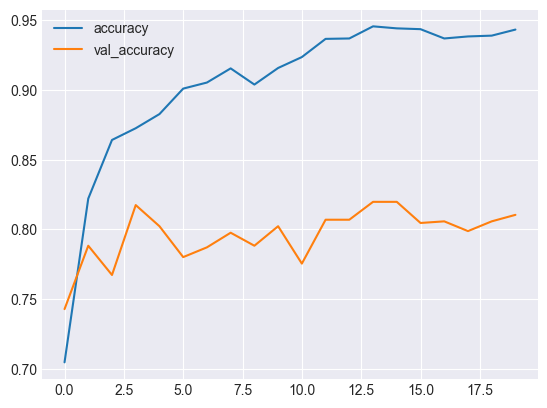

In [21]:
plot_accuracy(model_res_history)

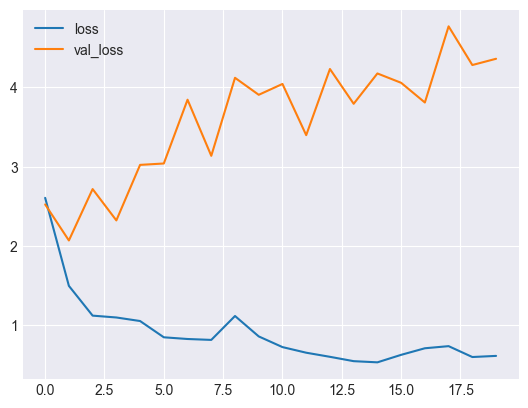

In [22]:
plot_loss(model_res_history)

In [23]:
model_res.save('model_res_original')

INFO:tensorflow:Assets written to: model_res_original/assets


INFO:tensorflow:Assets written to: model_res_original/assets


In [57]:
def model_report(model,test_img):
    predicts = model.predict(test_img)
    predicts_labels = [ labels[np.argmax(score)] for score in predicts ]
    
    
#     #Preview Predicts Image
    fig1, ax1 = plt.subplots(1,5,figsize=(25,5))
    ax1= ax1.flatten()
    fig1.suptitle("Image with Predicted Labels", fontsize=18)
    l1 = [ax1[i].imshow(test_img[i]) for i in range(5)]
    l1_label = [ax1[i].set_xlabel(predicts_labels[i]) for i in range(5)]
    
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(test_labels,predicts_labels,normalize='true'),display_labels=labels)
    disp.plot()
    plt.show()
  
                
                


In [69]:
from sklearn.utils import shuffle

pics = list()
pics_arr = list()
p_class = list()
files = list()

data_dir = Path("flowers")



# plt.figure(figsize=(20,5))
for idx, folder in enumerate(data_dir.glob('[!LICENSE]*')):
    for file in shuffle(list(data_dir.glob(folder.name+'/*')))[0:150]:
        files.append(file)

files = shuffle(files)

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(str(img), target_size=IMG_DIM)) for img in files]
test_imgs = np.array(test_imgs)
test_labels = [fn.parts[1] for fn in files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255   

    

24/24 [==============================] - 16s 678ms/step


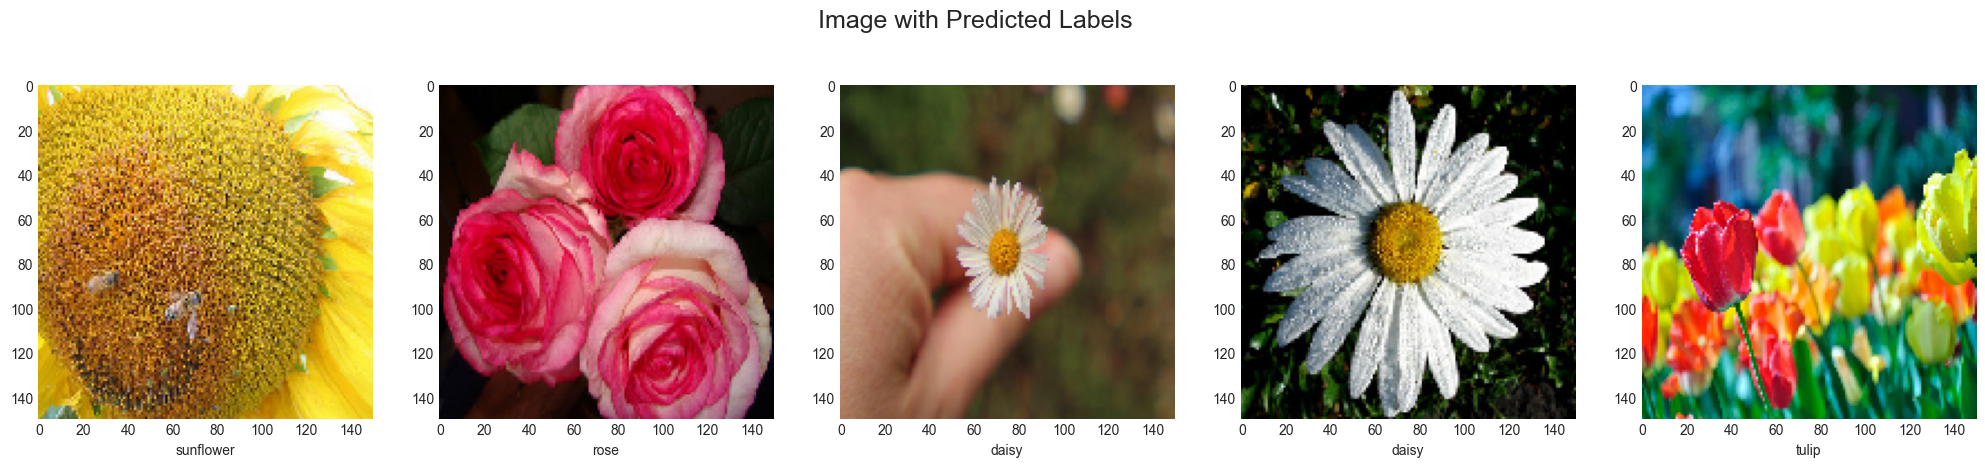

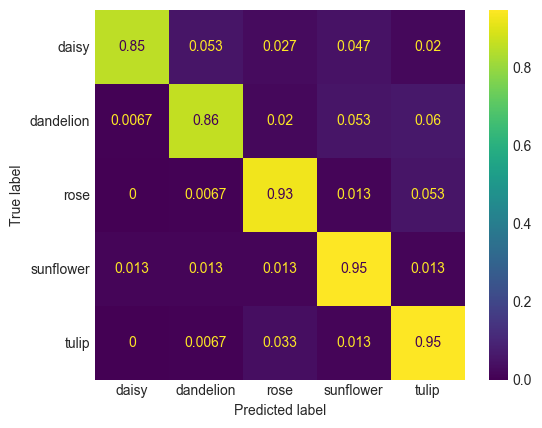

In [62]:
model_report(model_incept_original,test_imgs_scaled)

24/24 [==============================] - 89s 4s/step


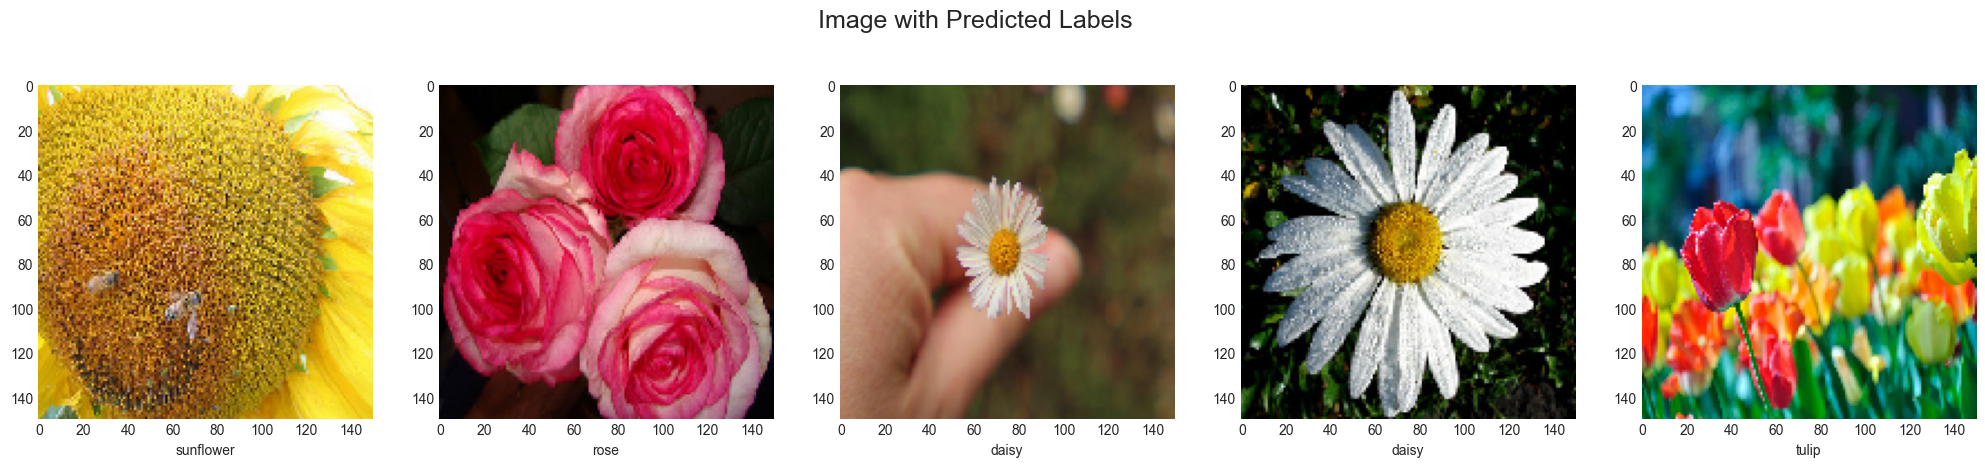

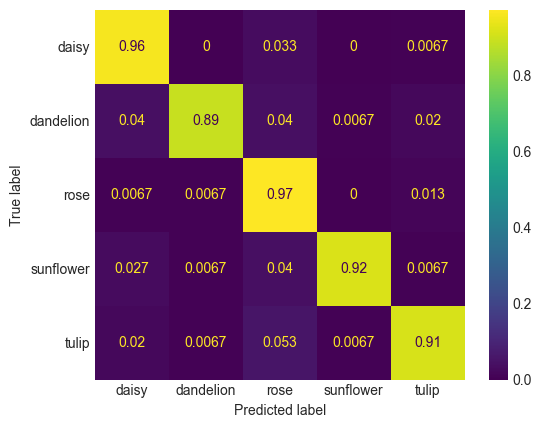

In [63]:
model_report(model_vgg16_original,test_imgs_scaled)

24/24 [==============================] - 11s 462ms/step


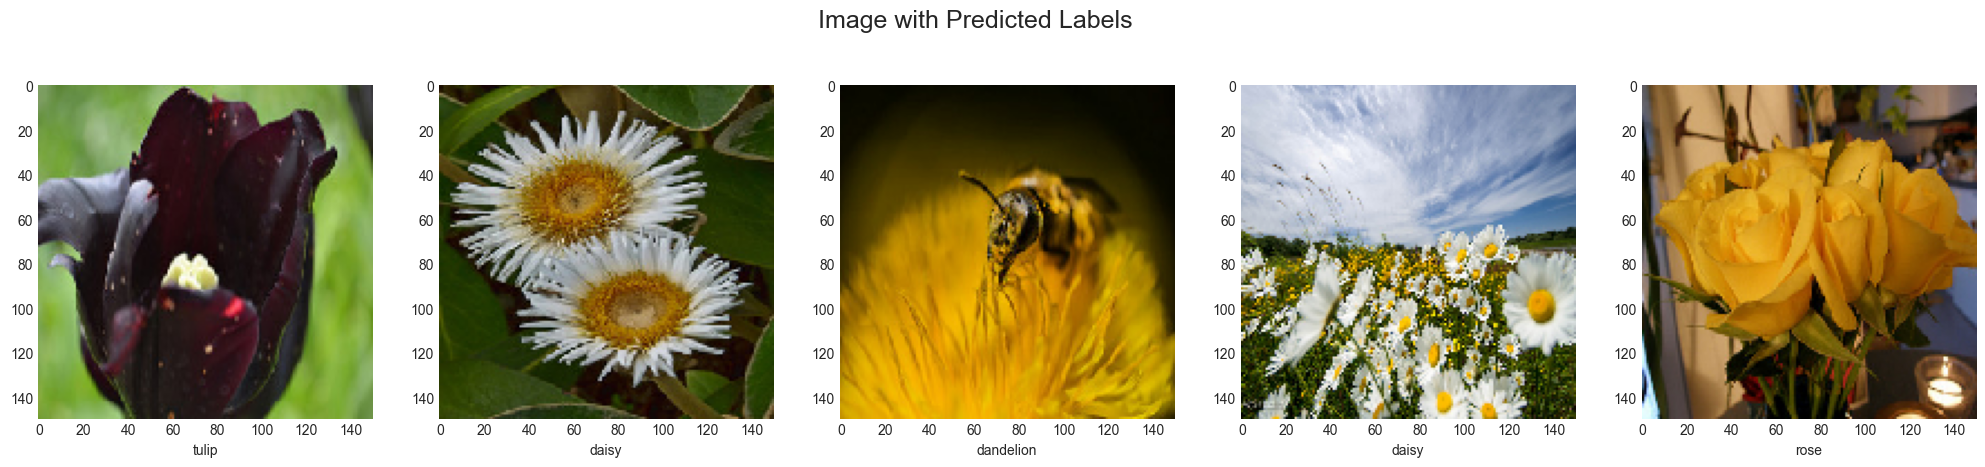

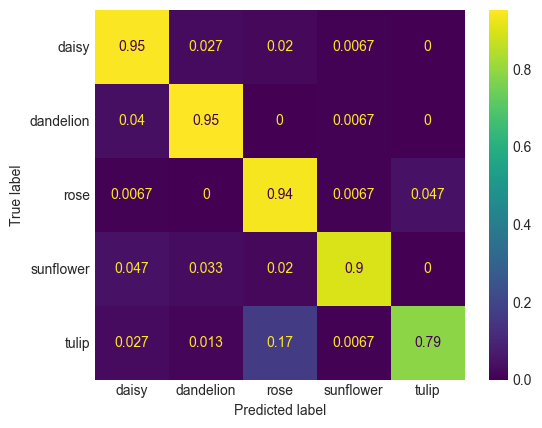

In [70]:
# model_incept_dense = tf.keras.models.load_model('model_incept_dense')
model_report(model_incept_dense,test_imgs_scaled)